<a href="https://colab.research.google.com/github/imhannnah/MINI_PROJECT-PLANT_LEAF_DISEASE_DITECTOR/blob/main/notebooks/EfficientNet_B0_Plant_Leaf_Disease_Detection_(Google_Colab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# EfficientNet-B0 — Plant Leaf Disease Detection (Google Colab)

This notebook trains an **EfficientNet-B0** classifier for plant leaf disease detection using PyTorch and torchvision.

**What you'll do:**
1. Check GPU and install dependencies (if needed).
2. Prepare the dataset (upload or mount Google Drive; auto split into train/val/test).
3. Build EfficientNet-B0 with ImageNet weights + augmentation.
4. Train with mixed precision, early stopping, and LR scheduler.
5. Evaluate (accuracy, classification report, confusion matrix) and visualize training curves.
6. Run single-image inference.
7. (Optional) Grad-CAM to visualize what the model looks at.

> **Dataset expectation**: an **ImageFolder**-style directory with subfolders per class, e.g.  
> `data/plantvillage/<class_name>/*.jpg`  
> If you already have separate folders `train/`, `val/`, `test/`, the notebook will detect and use them directly.


In [ ]:

#@title ✅ Runtime & GPU check
import sys, platform, torch

print("Python:", platform.python_version())
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("⚠️ No GPU detected. In Colab: Runtime ➜ Change runtime type ➜ Hardware accelerator = GPU")


Python: 3.12.11
PyTorch: 2.8.0+cu126
CUDA available: True
GPU name: Tesla T4


In [ ]:

#@title (Optional) Install/upgrade dependencies
# If you're in Colab, most are preinstalled. Uncomment if you need them.
# !pip install -q --upgrade torch torchvision torchaudio
# !pip install -q scikit-learn matplotlib pillow
# !pip install -q tqdm



## Data: mount Drive or upload

Pick **one**:
- **A. Mount Google Drive** and point `DATA_DIR` to your dataset folder in Drive.
- **B. Upload a ZIP** of your dataset and extract to `data/plantvillage`.
- **C. Provide a public path already in the runtime.


In [ ]:

#@title Choose data source
METHOD = "A"  #@param ["A", "B", "C"] {type:"string"}
DATA_DIR = "/content/drive/MyDrive/plant-leaf-disease/data/plantvillage"  #@param {type:"string"}

import os, shutil, zipfile
from pathlib import Path

if METHOD.upper() == "A":
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    root = Path(DATA_DIR)
    print("Mounted. Looking for data at:", root)

elif METHOD.upper() == "B":
    # Upload a zip file and extract to /content/data/plantvillage
    from google.colab import files
    up = files.upload()  # select your dataset zip
    assert len(up) == 1, "Please upload exactly one zip file."
    zip_name = list(up.keys())[0]
    target_dir = Path("/content/data/plantvillage")
    target_dir.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(zip_name, 'r') as zf:
        zf.extractall(target_dir)
    root = target_dir
    print("Extracted to:", root.resolve())

elif METHOD.upper() == "C":
    root = Path(DATA_DIR)
    print("Using existing path:", root.resolve())

else:
    raise ValueError("METHOD must be one of: 'A', 'B', 'C'")


Mounted at /content/drive
Mounted. Looking for data at: /content/drive/MyDrive/plant-leaf-disease/data/plantvillage



### Auto-detect split or create `train/val/test`

If your dataset already has `train/`, `val/`, `test/` folders, we'll use them.  
Otherwise, we'll **create** them by randomly splitting the data (80/10/10).


In [ ]:

#@title Prepare splits
import random, shutil
from pathlib import Path

random_seed = 42  #@param {type:"integer"}
train_ratio = 0.8  #@param {type:"number"}
val_ratio = 0.1    #@param {type:"number"}
test_ratio = 0.1   #@param {type:"number"}

assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1."

root = Path(root)
assert root.exists(), f"Data path not found: {root}"

# If already split, use it.
if (root / "train").exists() and (root / "val").exists():
    split_root = root
    print("Detected existing split at:", split_root.resolve())
else:
    # Expecting ImageFolder: root/<class>/*.jpg
    classes = [d.name for d in root.iterdir() if d.is_dir()]
    assert len(classes) > 0, f"No class subfolders found under {root}"
    split_root = Path("/content/data_split")
    (split_root / "train").mkdir(parents=True, exist_ok=True)
    (split_root / "val").mkdir(parents=True, exist_ok=True)
    (split_root / "test").mkdir(parents=True, exist_ok=True)

    random.seed(random_seed)
    for cls in classes:
        files = [p for p in (root / cls).glob("*") if p.is_file()]
        random.shuffle(files)
        n = len(files)
        n_train = int(n * train_ratio)
        n_val = int(n * val_ratio)
        train_files = files[:n_train]
        val_files = files[n_train:n_train+n_val]
        test_files = files[n_train+n_val:]

        for subset_name, subset_files in [("train", train_files), ("val", val_files), ("test", test_files)]:
            dest_dir = split_root / subset_name / cls
            dest_dir.mkdir(parents=True, exist_ok=True)
            for f in subset_files:
                shutil.copy2(f, dest_dir / f.name)

    print("Created split at:", split_root.resolve())

train_dir = split_root / "train"
val_dir = split_root / "val"
test_dir = split_root / "test" if (split_root / "test").exists() else None
print("train_dir:", train_dir)
print("val_dir:", val_dir)
print("test_dir:", test_dir)


Created split at: /content/data_split
train_dir: /content/data_split/train
val_dir: /content/data_split/val
test_dir: /content/data_split/test



## Datasets & Dataloaders
We use standard augmentations and resize to EfficientNet-B0's preferred input size (**224×224**).


In [ ]:

#@title Build datasets & dataloaders
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import EfficientNet_B0_Weights

batch_size = 32  #@param {type:"integer"}
num_workers = 2  #@param {type:"integer"}

weights = EfficientNet_B0_Weights.IMAGENET1K_V1
mean, std = weights.transforms().mean, weights.transforms().std

train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

valid_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds   = datasets.ImageFolder(val_dir,   transform=valid_tfms)
test_ds  = datasets.ImageFolder(test_dir,  transform=valid_tfms) if test_dir else None

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True) if test_ds else None

class_names = train_ds.classes
num_classes = len(class_names)
print("Classes:", class_names)
print("num_classes:", num_classes)


Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___


## Model: EfficientNet-B0 (transfer learning)
We load ImageNet weights and replace the classifier for our number of classes.


In [ ]:

#@title Create model
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = EfficientNet_B0_Weights.IMAGENET1K_V1
model = efficientnet_b0(weights=weights)

# Replace classifier head
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

model = model.to(device)
print(model.classifier)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 72.9MB/s]


Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=38, bias=True)
)



## Training utilities
Mixed precision (AMP), early stopping, and StepLR scheduler.


In [ ]:

#@title Train & validate helpers
import math, time
from tqdm import tqdm

def accuracy_from_logits(logits, targets):
    preds = logits.argmax(dim=1)
    correct = (preds == targets).sum().item()
    total = targets.size(0)
    return correct / total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, running_acc, n = 0.0, 0.0, 0
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)
        loss = criterion(outputs, targets)
        acc = accuracy_from_logits(outputs, targets)
        b = images.size(0)
        running_loss += loss.item() * b
        running_acc  += acc * b
        n += b
    return running_loss / n, running_acc / n

def train(
    model, train_loader, val_loader, device,
    epochs=10, lr=1e-3, weight_decay=1e-4, patience=3, grad_accum_steps=1
):
    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_val_loss = float("inf")
    best_state = None
    early_stop_counter = 0

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss, running_acc, n = 0.0, 0.0, 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False)
        optimizer.zero_grad(set_to_none=True)
        for step, (images, targets) in enumerate(pbar, start=1):
            images, targets = images.to(device), targets.to(device)

            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                outputs = model(images)
                loss = criterion(outputs, targets)
                acc = accuracy_from_logits(outputs, targets)
                loss = loss / grad_accum_steps

            scaler.scale(loss).backward()

            if step % grad_accum_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            b = images.size(0)
            running_loss += loss.item() * b * grad_accum_steps
            running_acc  += acc * b
            n += b
            pbar.set_postfix({"loss": f"{running_loss/n:.4f}", "acc": f"{running_acc/n:.4f}"})

        # End epoch
        scheduler.step()
        train_loss = running_loss / n
        train_acc  = running_acc / n

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch:02d}: train_loss={train_loss:.4f}  train_acc={train_acc:.4f}  val_loss={val_loss:.4f}  val_acc={val_acc:.4f}")

        # Early stopping
        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping.")
                break

    # Load best weights
    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history



## Train
Adjust hyperparameters as needed. If you run into memory issues, reduce `batch_size`.


In [ ]:

#@title Run training
epochs = 10       #@param {type:"integer"}
lr = 1e-3         #@param {type:"number"}
weight_decay = 1e-4  #@param {type:"number"}
patience = 3      #@param {type:"integer"}
grad_accum_steps = 1 #@param {type:"integer"}

trained_model, history = train(
    model, train_loader, val_loader, device,
    epochs=epochs, lr=lr, weight_decay=weight_decay,
    patience=patience, grad_accum_steps=grad_accum_steps
)


/tmp/ipython-input-682610598.py:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
Epoch 1/10:   0%|          | 0/1086 [00:00<?, ?it/s]/tmp/ipython-input-682610598.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 01: train_loss=0.2732  train_acc=0.9195  val_loss=0.0729  val_acc=0.9780


Epoch 02: train_loss=0.0980  train_acc=0.9695  val_loss=0.0685  val_acc=0.9822


Epoch 03: train_loss=0.0832  train_acc=0.9734  val_loss=0.0473  val_acc=0.9854


Epoch 04: train_loss=0.0253  train_acc=0.9921  val_loss=0.0120  val_acc=0.9954


Epoch 05: train_loss=0.0138  train_acc=0.9960  val_loss=0.0082  val_acc=0.9970


Epoch 06: train_loss=0.0125  train_acc=0.9964  val_loss=0.0086  val_acc=0.9968


Epoch 07: train_loss=0.0090  train_acc=0.9973  val_loss=0.0068  val_acc=0.9979


Epoch 08: train_loss=0.0071  train_acc=0.9978  val_loss=0.0079  val_acc=0.9968


Epoch 09: train_loss=0.0067  train_acc=0.9979  val_loss=0.0064  val_acc=0.9972


Epoch 10: train_loss=0.0061  train_acc=0.9984  val_loss=0.0060  val_acc=0.9979



## Training curves


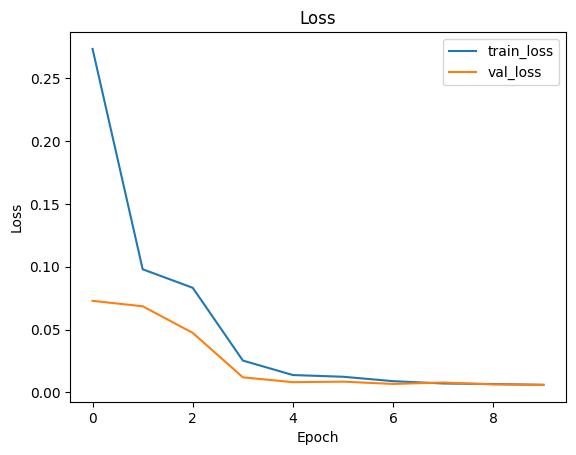

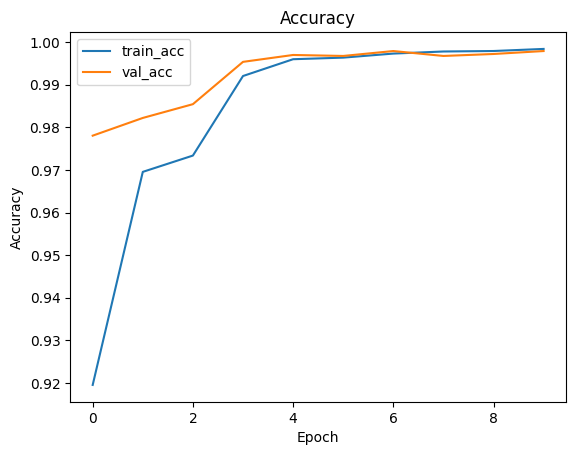

In [ ]:

#@title Plot training & validation curves
import matplotlib.pyplot as plt

def plot_history(history):
    # Loss
    plt.figure()
    plt.plot(history["train_loss"], label="train_loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(history["train_acc"], label="train_acc")
    plt.plot(history["val_acc"], label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy")
    plt.show()

plot_history(history)



## Evaluate on test set
If you created a test split, evaluate accuracy and show a confusion matrix.


                                                    precision    recall  f1-score   support

                                Apple___Apple_scab     1.0000    0.9804    0.9901        51
                                 Apple___Black_rot     1.0000    1.0000    1.0000        51
                          Apple___Cedar_apple_rust     1.0000    1.0000    1.0000        22
                                   Apple___healthy     1.0000    1.0000    1.0000       133
                               Blueberry___healthy     1.0000    1.0000    1.0000       121
          Cherry_(including_sour)___Powdery_mildew     1.0000    1.0000    1.0000        85
                 Cherry_(including_sour)___healthy     1.0000    1.0000    1.0000        70
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.9024    0.9024    0.9024        41
                       Corn_(maize)___Common_rust_     1.0000    1.0000    1.0000        96
               Corn_(maize)___Northern_Leaf_Blight     0.9500    0.9500    0.95

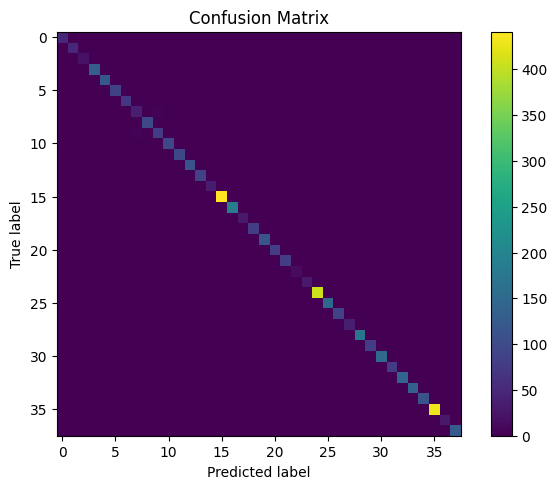

In [ ]:

#@title Test evaluation (optional if you have a test set)
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

if test_loader is None:
    print("No test set detected. Skip.")
else:
    trained_model.eval()
    all_targets, all_preds = [], []
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            outputs = trained_model(images)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(targets.numpy())

    print(classification_report(all_targets, all_preds, target_names=class_names, digits=4))

    cm = confusion_matrix(all_targets, all_preds)
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    #plt.xticks(tick_marks, class_names, rotation=90)
    #plt.yticks(tick_marks, class_names)
   # plt.xticks(tick_marks)
   # plt.yticks(tick_marks)
    plt.tight_layout()
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()



## Save model and class mapping


In [ ]:

#@title Save weights and label mapping
import json, os
save_dir = "/content/outputs"  # change to your Drive folder if using Drive
os.makedirs(save_dir, exist_ok=True)

weights_path = os.path.join(save_dir, "efficientnet_b0_plant_disease.pth")
torch.save(trained_model.state_dict(), weights_path)
print("Saved weights to:", weights_path)

label_path = os.path.join(save_dir, "class_to_idx.json")
class_to_idx = train_ds.class_to_idx
with open(label_path, "w") as f:
    json.dump(class_to_idx, f, indent=2)
print("Saved class mapping to:", label_path)


Saved weights to: /content/outputs/efficientnet_b0_plant_disease.pth
Saved class mapping to: /content/outputs/class_to_idx.json



## Single-image inference
Provide a path to a leaf image and get the predicted class.


Prediction: Grape___Black_rot (p=0.7210)


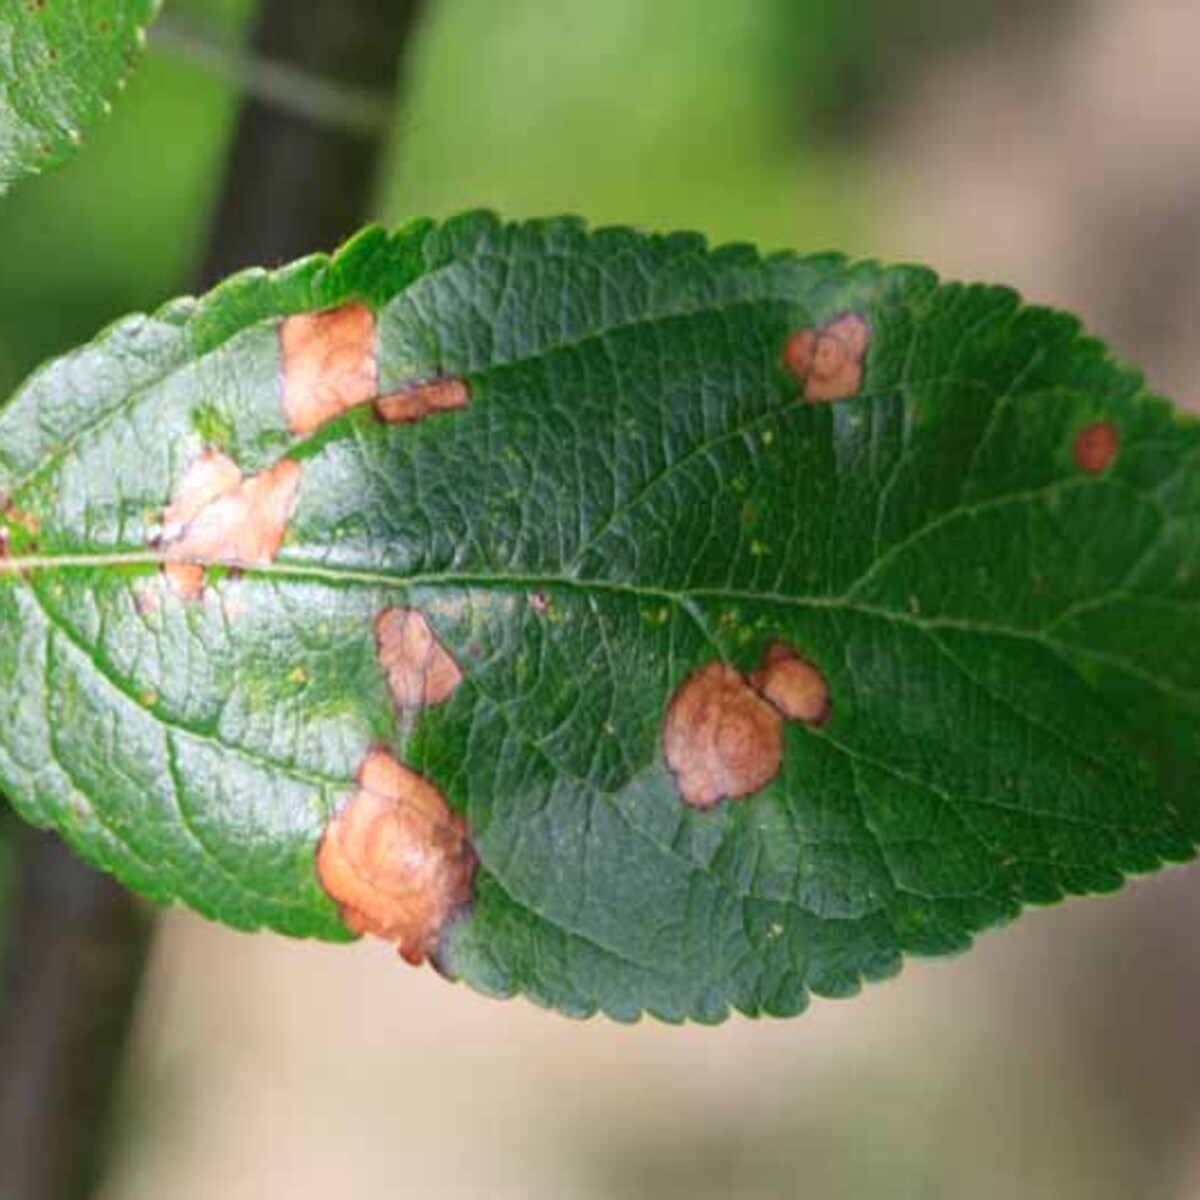

In [ ]:

#@title Predict on a single image
from PIL import Image
import torch.nn.functional as F

image_path = "/content/sample_leaf.jpg"  #@param {type:"string"}

img = Image.open(image_path).convert("RGB")
tfm = valid_tfms
x = tfm(img).unsqueeze(0).to(device)

trained_model.eval()
with torch.no_grad():
    logits = trained_model(x)
    probs = F.softmax(logits, dim=1).cpu().numpy()[0]
    pred_idx = int(probs.argmax())
    pred_class = class_names[pred_idx]
    confidence = float(probs[pred_idx])

print(f"Prediction: {pred_class} (p={confidence:.4f})")
display(img)



## (Optional) Grad-CAM
Visualize which regions influenced the prediction most.


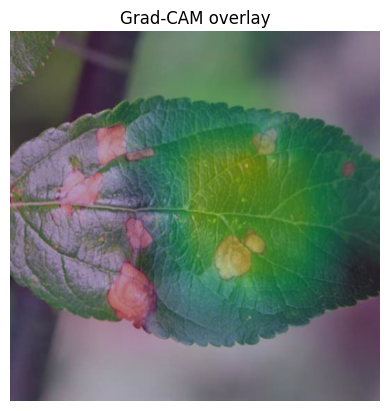

In [ ]:

#@title Grad-CAM for EfficientNet-B0 (last conv features)
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def gradcam(model, image_tensor, target_class=None):
    model.eval()

    conv_out = None
    gradients = None

    def fwd_hook(module, inp, out):
        nonlocal conv_out
        conv_out = out

    def bwd_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]

    # EfficientNet-B0 last features block
    handle_fwd = model.features.register_forward_hook(fwd_hook)
    handle_bwd = model.features.register_full_backward_hook(bwd_hook)

    image_tensor = image_tensor.requires_grad_(True)
    logits = model(image_tensor)
    if target_class is None:
        target_class = logits.argmax(dim=1).item()

    loss = logits[:, target_class].sum()
    model.zero_grad(set_to_none=True)
    loss.backward()

    # Compute weights: global-average-pool the gradients
    pooled_grads = gradients.mean(dim=[0, 2, 3], keepdim=True)  # [C,1,1]

    # Weight the conv feature maps
    cam = (pooled_grads * conv_out).sum(dim=1, keepdim=True)  # [1,1,H,W]
    cam = torch.relu(cam)
    cam = cam.squeeze().detach().cpu().numpy()

    # Normalize between 0 and 1
    cam -= cam.min()
    cam /= (cam.max() + 1e-8)
    handle_fwd.remove()
    handle_bwd.remove()
    return cam

# Run Grad-CAM on the same image_path as above
img = Image.open(image_path).convert("RGB")
x = valid_tfms(img).unsqueeze(0).to(device)

cam = gradcam(trained_model, x)

# Resize cam to image size
cam_img = Image.fromarray((cam * 255).astype(np.uint8)).resize(img.size, Image.BILINEAR)
cam_np = np.array(cam_img) / 255.0

# Overlay without specifying colors: use matplotlib default
plt.figure()
plt.imshow(img)
plt.imshow(cam_np, alpha=0.4)
plt.title("Grad-CAM overlay")
plt.axis("off")
plt.show()



## Tips & Troubleshooting
- If you get **OOM (out-of-memory)** errors: reduce `batch_size`, or set `grad_accum_steps` to 2 or 4.
- If validation accuracy stalls: increase epochs, decrease LR (`1e-4`), or try stronger augmentation.
- Your dataset should be balanced and clean. Remove near-duplicates and extremely blurry images.
- To continue training later, reload weights from the saved `.pth` and keep the same `class_to_idx.json`.
